In [1]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os
import pandas as pd

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import spectools_ir
print(spectools_ir.__file__)

/Users/belaarwen/opt/anaconda3/lib/python3.9/site-packages/spectools_ir/__init__.py


# Flux_calculator example use

Flux calculator will loop through a set of provided wavelengths, then perform a Gaussian and numerical computation of line flux at each location.  If one begins by using the helper tool "extract_hitran_data", the output will include transition-specific data in addition to the computed line fluxes.

### Read in HITRAN data with extract_hitran_data

This example uses extract_hitran_data to find fundamental CO vibrational transitions in the M band.  A spectrum is read in from a FITS file.

In [35]:
hitran_data_CO=extract_hitran_data('CO',5.3,5.42,vup=1)                    #calling for CO lines
hitran_data_H2O=extract_hitran_data('H2O',5.3,5.42,eupmax=4000,aupmin=0)    #calling for H2O lines 
                                                                        #eupmax gives a maximum to the energy transition in ___?
                                                                        #aupmin gives __?__

#This line calls to the hitran dataset and labels an astropy table as "hitran_data". 
#We are calling for CO and H2O from the 5.3 to the 5.42 micron regime 

In [36]:
extract_hitran_data

<function spectools_ir.utils.utils.extract_hitran_data(molecule_name, wavemin, wavemax, isotopologue_number=1, eupmax=None, aupmin=None, swmin=None, vup=None)>

In [37]:
#Read in FITS data containing spectrum.
#infile='/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/FZTau_orders.fits'     
#infile2='CITau.fits'    #these are the only 3 with our target regime
#infile3='IQTau.fits'

 
#hdulist=fits.open(infile)      #hdu means header data unit so we are creating a list of header data units to use in further files 
#data=hdulist[1].data
#wave=data['wave'][0]*1/e-3
#flux=data['flux'][0]


hdulist.info




<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f9ba8f01370>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f9b50035760>]>

In [ ]:
sources_list = ['FZTau','CITau','IQTau','FZ','','','']

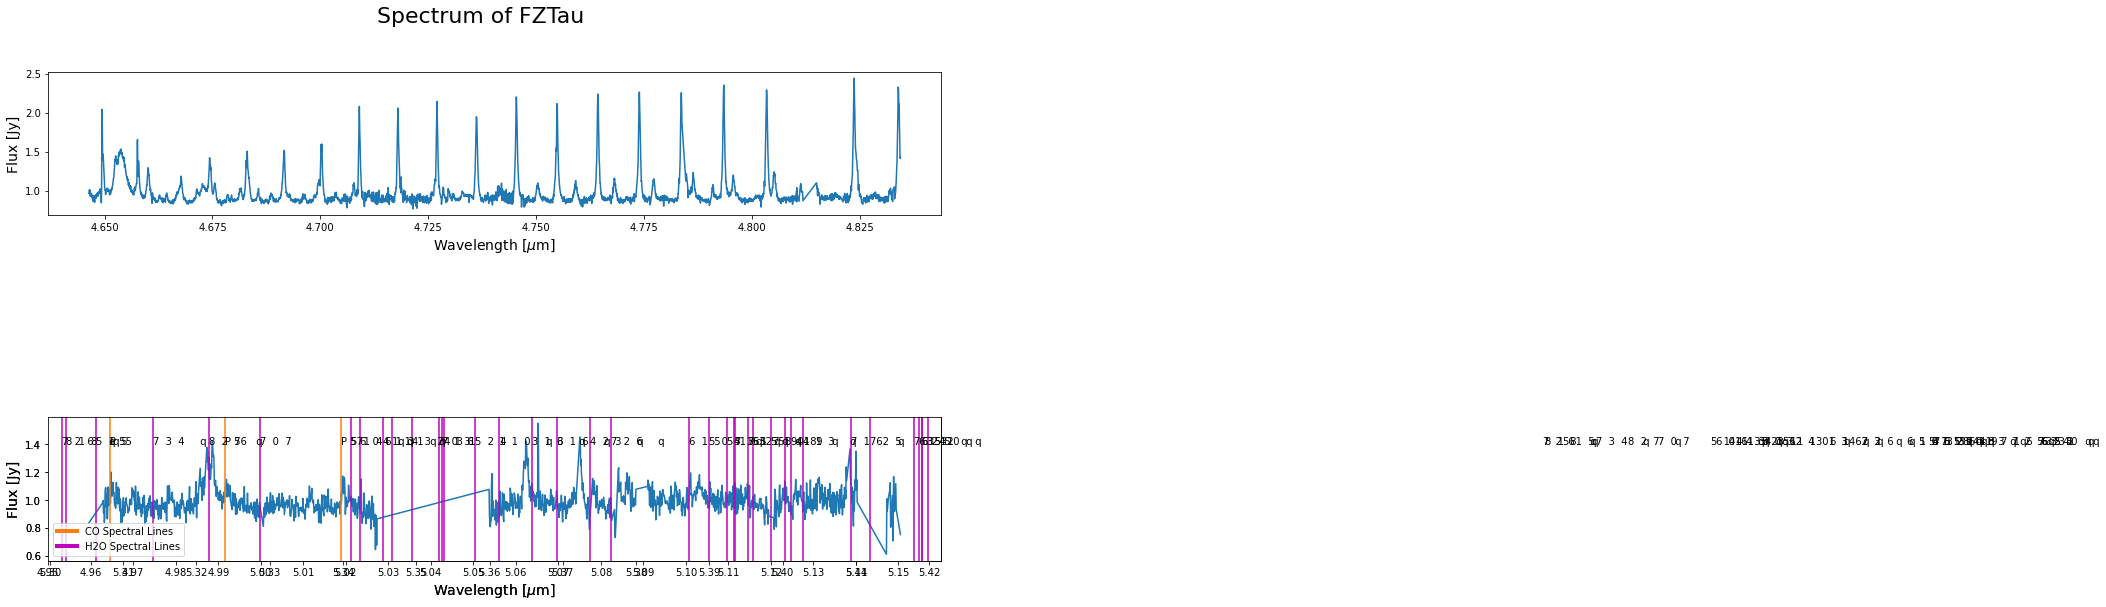

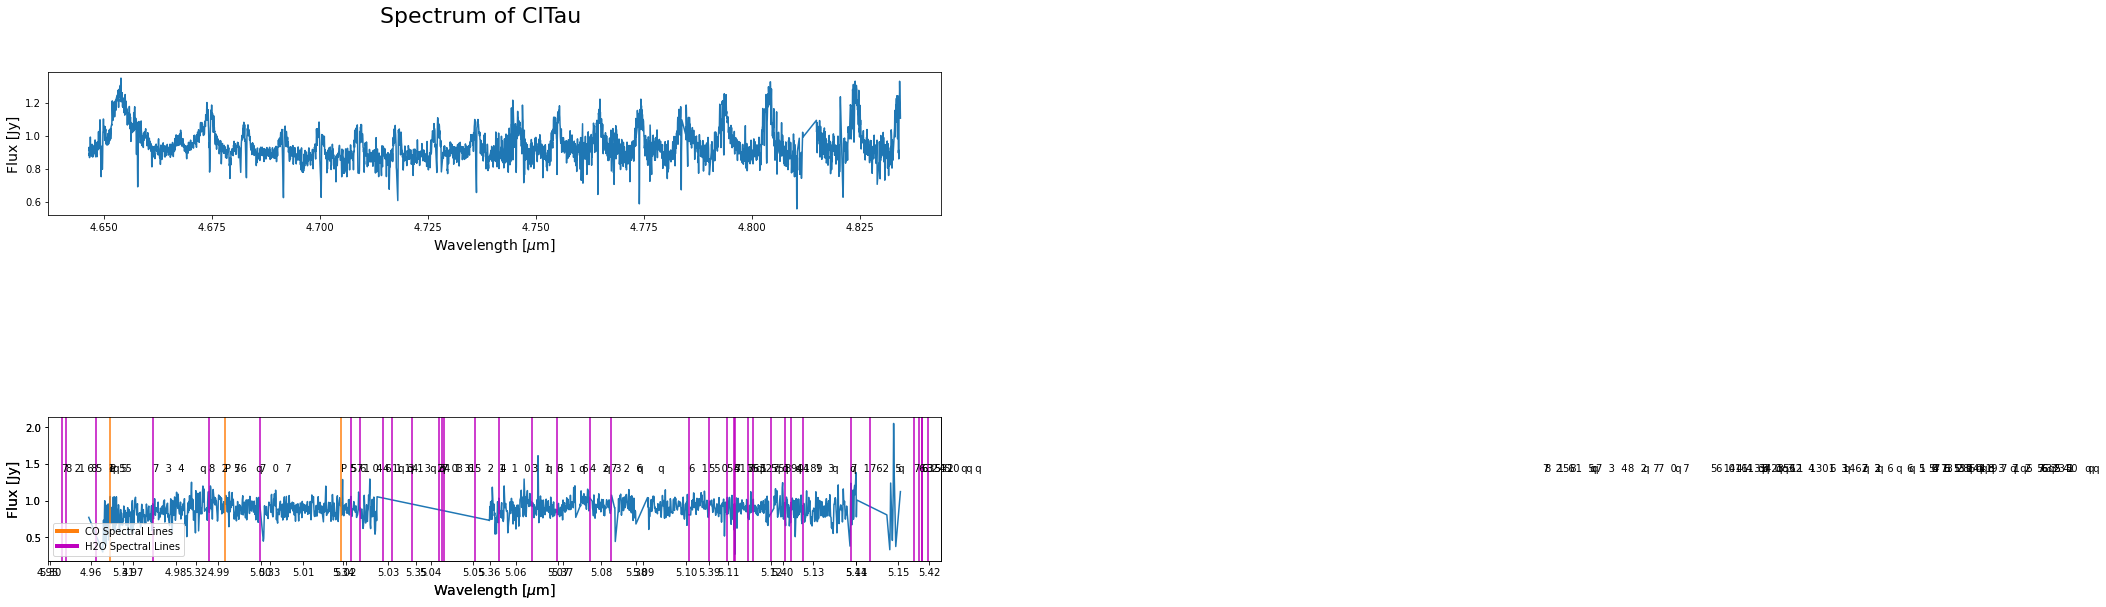

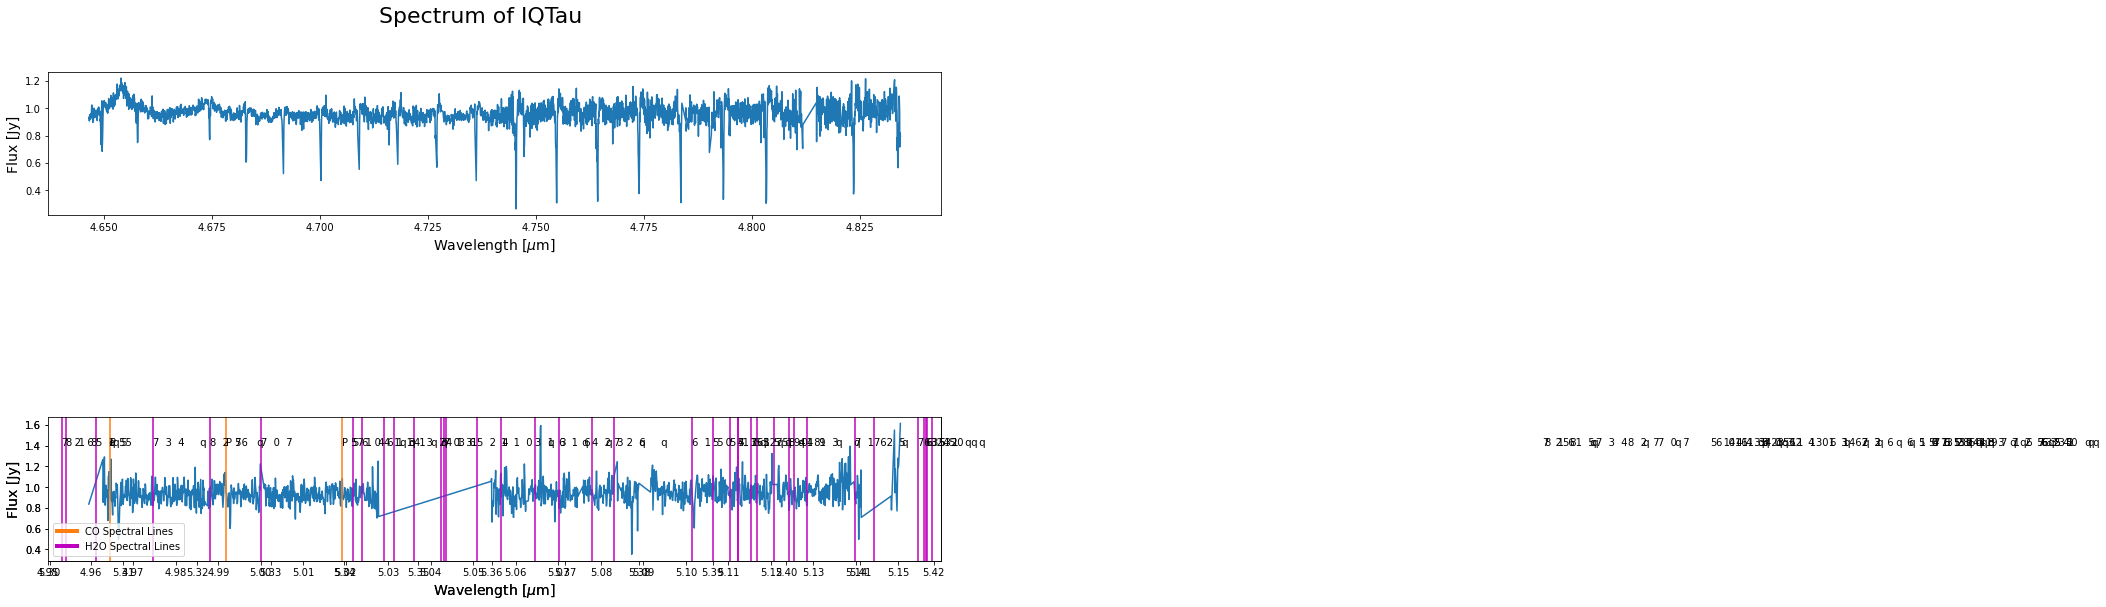

In [44]:
for i in ['FZTau','CITau','IQTau', ]:
    
    #Read in FITS data containing spectrum.
    infile='/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+j+'_orders.fits'
    hdulist=fits.open(infile)
    data=hdulist[1].data
    wave=data['wave']*1e-3
    flux=data['flux']


# I wanted to add a third subplot for the new order but I found that having multiple subplots with separate axis limits
# causes some weird (but well-documented) scaling issues in the final figure. I removed the axis limits by sorting the data
# into orders in Pandas DataFrames. That way, the plots would generate their own x limits. This seemed to fix the scaling issue
# and helped me get a little better at using Matplotlib.



    # Making the data into floats so that it plays nicely with Pandas:
    float_waves  = []
    float_fluxes = []
    for i in wave:
        float_waves.append(float(i))
    for i in flux:
        float_fluxes.append(float(i))

    # Building a DataFrame
    all_data     = pd.DataFrame(data={'wave':np.array(float_waves),'flux':np.array(float_fluxes)}).dropna().sort_values(by='wave').reset_index(drop=True)
    first_order  = all_data.loc[all_data['wave']<0.0049]
    second_order = all_data.loc[all_data['wave']>=0.0049].loc[all_data['wave']<0.0052]
    third_order  = all_data.loc[all_data['wave']>=0.0052]

    first_order_wave  = np.array(first_order['wave'])
    second_order_wave = np.array(second_order['wave'])
    third_order_wave  = np.array(third_order['wave'])
    first_order_flux  = np.array(first_order['flux'])
    second_order_flux = np.array(second_order['flux'])
    third_order_flux  = np.array(third_order['flux'])

    #Plot spectrum.

    fig=plt.figure(figsize=(16,9))
    
    fig.suptitle('Spectrum of '+j,fontsize=22)

    ax1=fig.add_subplot(311)
    ax1.plot(first_order_wave*1e3,first_order_flux)
    #ax1.set_xlim(4.64,4.78)
    for i,mywave in enumerate(hitran_data['wave']):
        if( (mywave>4.64) & (mywave<4.83) ):
            ax1.axvline(mywave,color='C1')
            ax1.text(hitran_data_CO['wave'][i],1.4,hitran_data_CO['Qpp'][i].strip())
    ax1.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
    ax1.set_ylabel('Flux [Jy]',fontsize=14)

   

   if len(third_order_wave) != 0:
        ax3=fig.add_subplot(313)
        ax3.plot(third_order_wave*1e3,third_order_flux)
        #ax3.set_xlim(5.3,5.42)
        for i,mywave in enumerate(hitran_data_CO['wave']):
            if( (mywave>5.3) & (mywave<5.42) ):
                ax3.axvline(mywave,color='C1')
                ax3.text(hitran_data_CO['wave'][i],1.4,hitran_data_CO['Qpp'][i].strip())
        for i,mywave in enumerate(hitran_data_H2O['wave']):
            if( (mywave>5.3) & (mywave<5.42) ):
                ax3.axvline(mywave,color='m')
                ax3.text(hitran_data_H2O['wave'][i],1.4,hitran_data_H2O['Qpp'][i].strip())
        ax3.legend([Line2D([0], [0], color='C1', lw=4), Line2D([0], [0], color='m', lw=4)], ['CO Spectral Lines', 'H2O Spectral Lines'], loc='lower left')
        ax3.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
        ax3.set_ylabel('Flux [Jy]',fontsize=14)
        plt.xticks(ticks=arange(5.3,5.43,0.01))
    
    if len(third_order_wave) != 0:
        ax3=fig.add_subplot(313)
        ax3.plot(third_order_wave*1e3,third_order_flux)
        #ax3.set_xlim(5.3,5.42)
        for i,mywave in enumerate(hitran_data_CO['wave']):
            if( (mywave>5.3) & (mywave<5.42) ):
                ax3.axvline(mywave,color='C1')
                ax3.text(hitran_data_CO['wave'][i],1.4,hitran_data_CO['Qpp'][i].strip())
        for i,mywave in enumerate(hitran_data_H2O['wave']):
            if( (mywave>5.3) & (mywave<5.42) ):
                ax3.axvline(mywave,color='m')
                ax3.text(hitran_data_H2O['wave'][i],1.4,hitran_data_H2O['Qpp'][i].strip())
        ax3.legend([Line2D([0], [0], color='C1', lw=4), Line2D([0], [0], color='m', lw=4)], ['CO Spectral Lines', 'H2O Spectral Lines'], loc='lower left')
        ax3.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
        ax3.set_ylabel('Flux [Jy]',fontsize=14)
        plt.xticks(ticks=arange(5.3,5.43,0.01))


    #plt.tight_layout()
    
    
    plt.show()

In [ ]:
#Plot spectrum.
fig=plt.figure(figsize=(12,6))   # creating a plot 

ax1=fig.add_subplot(211)         #creating a subplot
ax2=fig.add_subplot(211)
ax3=fig.add_subplot(211)
ax1.plot(wave,flux)              #plotting the wave vs the flux on the subplot just created 
ax1.set_xlim(4.64,4.78)          #setting the limits of the axis to a range which we can 
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.64) & (mywave<4.78) ):
        ax1.axvline(mywave,color='C1')
        ax1.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
ax1.set_ylabel('Flux [Jy]',fontsize=14)

ax2=fig.add_subplot(212)         #creating a second subplot for the second wavelength range
ax2.plot(wave,flux)              #plotting the wave vs the flux on the subplot just created 
ax2.set_xlim(4.8,4.92)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.8) & (mywave<4.92) ):
        ax2.axvline(mywave,color='C1')
        ax2.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
ax2.set_ylabel('Flux [Jy]',fontsize=14)

### Calculate line fluxes for dataset, using locations specified in hitran dataset

calc_fluxes is now used to compute the line fluxes in the spectrum.  (Some additional code is added to read and write in the flux values for use in later parts of this notebook.)  Users can provide input values of the continuum level (cont), FWHM (fwhm_v) and Doppler shift of lines relative to vacuum rest wavelength (v_dop).  Users can also choose the size of the fit interval (sep_v), whether or not to vet the fits (vet_fits; highly recommended) and whether or not to plot (highly recommended).   The routine does little to no vetting on its own, so user vetting is highly recommended.

In [ ]:
#Calculate fluxes.
#Uncomment the following two lines to run the code
#lineflux_data=calc_fluxes(wave,flux,hitran_data, v_dop=0,fwhm_v=40.,sep_v=200.,cont=1.05,vet_fits=True, plot=True)
#pickle.dump(lineflux_data,open('lineflux_data.p','wb')) #save for convenience

lineflux_data=pickle.load(open('lineflux_data.p','rb'))  #restore lineflux_data if you don't want to re-run

Note that flux_calculator calculates fluxes using both a Gaussian fit and numerical integration.  The numerical integration sums from -3$\sigma$ to +3$\sigma$, where $\sigma$ is provided by the Gaussian fit. These values should be similar for Gaussian line shapes, but may be quite different for more complex line shapes, as for AA Tau. 

The figure below shows how the two compare for this example.

In [ ]:
lineflux_data

In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineflux_data['wave'],lineflux_data['lineflux']*1e16, label='Numerical flux')
ax1.plot(lineflux_data['wave'],lineflux_data['lineflux_Gaussian']*1e16 ,label='Gaussian flux')
ax1.legend()
ax1.set_xlabel('Wavelength [microns]')
ax1.set_ylabel(r'Line flux [10$^{-16}$ W m$^{-2}$]')

Note that, although calc_fluxes takes a full "hitran_data" table as input, the most minimal table it can function with is one that just contains a column named "wave", which holds wavelengths in microns.

In [ ]:
#Create minimal hitran database for testing.  It only includes wavelengths.
test_hitran_data=hitran_data[['wave']].copy()

test_lineflux_data=calc_fluxes(wave,flux,test_hitran_data,v_dop=0,fwhm_v=40.,sep_v=200.,cont=1.05,vet_fits=True, plot=True)

You get out what you put in, though, so your output table will only have wavelengths and fit parameters (no HITRAN transition information).

In [ ]:
test_lineflux_data

### Create a composite lineshape using info from flux_calculator output

Flux calculator also has a routine that can make a composite lineshape from calc_fluxes output.

In [ ]:
lineshape_data=make_lineshape(wave,flux,lineflux_data)

In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineshape_data[0],lineshape_data[1])

ax1.set_xlabel('Velocity [km/s]')
ax1.set_ylabel('Arbitrary flux')

As with calc_fluxes, the routine can work with a minimal input table that includes a column named 'wave'.

In [ ]:
lineflux_data_minimal=lineflux_data['wave'].copy()
lineshape_data_minimal=make_lineshape(wave,flux,lineflux_data)

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineshape_data_minimal[0],lineshape_data_minimal[1])

ax1.set_xlabel('Velocity [km/s]')
ax1.set_ylabel('Arbitrary flux')

### Display resultant fluxes in a rotation diagram

Spectools_ir.utils has a function to make a rotation diagram, which can use calc_fluxes output as its dataset.  This example compares rotation diagrams for the Gaussian and numerical fluxes.

make_rotation_diagrams has a "units" keyword with values 'mks' (SI), 'cgs', or 'mixed'. Based on some precedent in the literature, 'mixed' units keeps most values in SI units, but wavenumbers in inverse cm.

In [ ]:
rot_numerical=make_rotation_diagram(lineflux_data,fluxkey='lineflux')
rot_Gaussian=make_rotation_diagram(lineflux_data,fluxkey='lineflux_Gaussian')

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rot_numerical['x'],rot_numerical['y'],'C0o',label='Numerical fit')
ax1.plot(rot_Gaussian['x'],rot_Gaussian['y'],'C1o', label='Gaussian fit')

ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.legend()

# Slabspec example use

Slabspec makes a model spectrum from a "slab" of gas - a column of gas with defined area, column density, and (single) temperature. The example below shows the creation of a CO spectrum from 4.58 to 5.2 microns.  Units are assumed to be SI (mks).  If convol_fwhm is specified, the model output will be convolved with a Gaussian with the given FWHM value (in km/s).  Both the convolved and unconvolved spectra are included in the output.

**Important note**: The model can produce wonky output if the model resolution ('res' parameter: resolution in microns) is not sufficient.  It's highly recommended that one check the output of a model against a model with higher resolution to make sure the output remains the same.

### Make a slab model spectrum with make_spec

In [ ]:
au=1.5e11
#Make slab model
#This can take a few seconds to run.  It is primarily limited by the convolution time.
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.2,convol_fwhm=30.,d_pc=140.,res=1e-5,vup=1)

In [ ]:
#Plot slab model
fig=plt.figure(figsize=(10,3))
ax1=fig.add_subplot(111)
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['flux']+1,label='Not convolved')
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['convolflux']+1,'r',label='Convolved')
ax1.legend()

### Output model fluxes as a rotation diagram (compare to data if desired)

Output from slabspec can also be displayed as a rotation diagram.

In [ ]:
rd_model=make_rotation_diagram(model_output['lineparams'])
rd_data=make_rotation_diagram(lineflux_data)

In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rd_model['x'],rd_model['y'],' C0o',label='Model')
ax1.plot(rd_data['x'],rd_data['y'],' C1*',label='Data')
ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.set_xlim(3000,4700)
ax1.set_ylim(-57,-52.5)
ax1.legend()

# Slab_fitter example use

slab_fitter uses the MCMC fitting code "emcee" to fit line fluxes with a slab model.  Priors are assumed to be flat, with boundaries provided by the user as input parameters.

In contrast to the slab model, slab_fitter uses solid angle in place of area.  Helper functions calc_solid_angle(radius, distance) and calc_radius(solid_angle,distance) can be used to convert between the two.  Calculations assume a face-on disk shape.

### Set up configuration

Configuration parameters are all stored in config.json, or another user-specified json file.  User must specify the range of temperatures, column densities, and solid angles, the number of walkers, the number of burnin samples, and the number of samples per walker.

slab_fitter naturally takes output of flux_calculator as input. (Other input examples are discussed below).

In [ ]:
myconfig=Config()  #reads config.json by default, or can specify path to file as input parameter
myconfig.display()

data=lineflux_data

mydata=LineData(data)
myretrieval=Retrieval(myconfig,mydata)

### Run retrieval

Running the retrieval can take a significant amount of time, so only run when ready. (Code below currently takes 9 minutes on my personal laptop.)

In [ ]:
#mychain=myretrieval.run_emcee()  #Run retrieval.  May take a while, depending on number of samples
#pickle.dump(mychain,open('test_chain.p','wb'))  #Save for convenience and later retrieval
#os.system('afplay /System/Library/Sounds/Sosumi.aiff')

mychain=pickle.load(open('test_chain.p','rb'))  
postsamples=get_samples(mychain,myconfig.getpar('Nburnin'))  #Get list of samples, after removing burnin, from chain

### Evaluate retrieval results

slab_fitter includes a few simple routines for evaluating and viewing the retrieval results.

**Note:** The examples here are not necessarily well-behaved samples.  Users should refer to emcee documentation and other sources for more info about MCMC sample vetting.

In [ ]:
#Trace plot - examine samples
trace_plot(postsamples)

In [ ]:
#Corner plot - see posterior distributions
fig=corner_plot(postsamples)

In [ ]:
#Best fit parameters - best fit parameters plus/minus 1-sigma intervals
best_fit=find_best_fit(postsamples,show=True)

In [ ]:
#Rotation diagram
modelflux=compute_model_fluxes(mydata,postsamples) #Compute model fluxes for ecah line in data
rotdiag=mydata.rot_diagram(modelfluxes=modelflux,units='mks') #Rotation diagram for data and model

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rotdiag['x'],rotdiag['modely'],'bo',label='Model')
ax1.plot(rotdiag['x'],rotdiag['modely'],'b',label='_None_')
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')

ax1.set_xlabel('Upper Level Energy [Kelvin]')
#ax1.set_ylabel(r'F[W m$^{-2}$]/($\~{\nu}$ [m$^{-1}$]g A[s$^{-1}$])',fontsize=14)
ax1.set_ylabel(r'F]/($\~{\nu}$ g A)',fontsize=14)
ax1.legend()

While slab_fitter naturally works with flux_calculator output, the "read_data_from_file" routine is provided as a way to read a minimal column-delimited file, and output a slab_fitter-ready data frame.  A file must contain the columns:  'molec' (e.g., "H2O"), 'iso' (1 for most common, 2 for second most common, etc.),'lineflux' (W/m$^2$), 'error'  (W/m$^2$), and either 'wn'(cm$^{-1}$) or 'wave' (microns).  

**Important note**: read_data_from_file will use your input molecular parameters and wavelength or wavenumber to find other transition parameters in the HITRAN database.  Since it has limited information, it simply finds the transition with the closest wavelength.  Therefore, the wavelengths must be precise.  It's a good idea to check the output before proceeding further, to make sure the transitions are what you expect.

In [ ]:
!cat 'slab_fitter_input.txt'  #This did not work initially, becuase I had just copied the text. How do I distinguish columns in .txt files?

data=read_data_from_file('slab_fitter_input.txt')   

In [ ]:
data  #Are these the transitions you want?

In [ ]:
myconfig=Config()  #reads config.json by default, or can specify path to file
myconfig.display()

mydata=LineData(data)
#myretrieval=Retrieval(myconfig,mydata)  #Commented out because this line of code takes a long time to run.

# Example use of some utils functions

spectools_ir.utils contains a few other commonly-used utilities that one may find helpful for analyis of IR spectroscopy, including some routines specific to JWST-MIRI MRS.

### Extract HITRAN data for any molecule in the database

In [ ]:
hitran_data=extract_hitran_data('CH3OH',10,11,isotopologue_number=1,eupmax=5000,aupmin=0.1)  #Outputs an astropy table

In [ ]:
hitran_data

### Convolve a spectrum with a Gaussian spectral response function

Note: Convolving a spectrum is conceptually simple, but edge effects and NaNs in spectral data can cause headaches.  This routine deals nicely with both of those issues (though it's not fast)

In [ ]:
au=1.5e11
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.6,wmax=4.62,d_pc=140.,res=1e-5)
wave=model_output['spectrum']['wave']
flux=model_output['spectrum']['flux']
convolflux=spec_convol(wave,flux,30.)  #Inputs: wavelength, flux, FWHM of Gaussian SRF in km/s

In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(wave,flux,label='Pre-convolved spectrum')
ax1.plot(wave,convolflux,label='Convolved spectrum')
ax1.set_xlabel(r'Wavelength [$\mu$m]')
ax1.set_ylabel('Flux [Jy]')
ax1.legend()

### Convolve spectrum with a wavelength-dependent SRF

A utility function is provided that allows for a wavelength-dependent spectral response function (SRF).  Input spectral resolution must either be a single element (i.e., non wavelength-dependent) or have the same number of elements as the spectrum.  Note the resolution is given as $R = \frac{\lambda}{\Delta \lambda}$ rather than $v$ in this function.

In [ ]:
au=1.5e11
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.6,wmax=4.62,d_pc=140.,res=1e-5)
wave=model_output['spectrum']['wave']
flux=model_output['spectrum']['flux']
myR=np.linspace(10000,25000.,num=np.size(wave))
convolflux=spec_convol_R(wave,flux,myR)  #Inputs: wavelength, flux, spectral resolution of Gaussian SRF
                                         #myR must either have 1 value, or be an array of same size as wave and flux

In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(wave,flux,label='Pre-convolved spectrum')
ax1.plot(wave,convolflux,label='Convolved spectrum')
ax1.set_xlabel(r'Wavelength [$\mu$m]')
ax1.set_ylabel('Flux [Jy]')
ax1.legend()

#Note the wavelength-dependent line width

### Some utility functions specific to JWST MIRI-MRS

A simple routine is provided to approximate Figure 14 from Wells et al. 2015, which provides R as a function of wavelength.  This function utilizes linear approximations and should only be used as a rough reference.

In [ ]:
make_miri_mrs_figure(figsize=(7,3))

get_miri_mrs_wavelengths provides the wavelength limits of an MRS sub-band

In [ ]:
get_miri_mrs_wavelengths('1A')

The covolution routine can be combined with slabspec output to create a model with a wavelength-dependent SRF

In [ ]:
#Get resolution for a range of wavelengths and use as input to wavelength-dependent convolution
au=1.5e11
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.87,wmax=5.,d_pc=140.,res=1e-5)
wave=model_output['spectrum']['wave']
flux=model_output['spectrum']['flux']

#Use get_miri_mrs_resolution to get wavelength resolution array
myR=get_miri_mrs_resolution('1A',wave)

convolflux=spec_convol_R(wave,flux,myR)  #Inputs: wavelength, flux, spectral resolution of Gaussian SRF
                
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(wave,flux,label='Pre-convolved spectrum')
ax1.plot(wave,convolflux,label='Convolved spectrum')
ax1.set_xlabel(r'Wavelength [$\mu$m]')
ax1.set_ylabel('Flux [Jy]')
ax1.legend()

### Other small helper functions

In [ ]:
print(sigma_to_fwhm(20.))

print(fwhm_to_sigma(47.096))

print(get_molmass('H2O',isotopologue_number=2))

print(compute_thermal_velocity('H2',500.))
print(compute_thermal_velocity('H2',1000.))

print(wn_to_k(2000./u.cm))